# Newspaper Scraping and Sentiment Analysis

# Mary Donovan Martello

## The goal of this project is to scrape newspaper websites for headlines and full articles and to perform sentiment analysis on the text.

In [2]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import feedparser as fp
import json
import newspaper
from newspaper import Article
from time import mktime
from datetime import datetime
import csv
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer


import sys
import joblib

import warnings
warnings.simplefilter("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\trave\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Part 1:  Web Scraping of Newspaper Sites

In [3]:
# set variables
# limit for number of articles to download from websites
limit = 50
data = {}
data['newspapers'] = {}

In [4]:
# Loads the JSON files that contains url's of news sites
with open('NewsPapers2.json') as data_file:
    companies = json.load(data_file)

### The code in the following block comes from: https://github.com/taubergm/NewsHeadlines  I made a few modifications to include the full text of the articles in the dataframe instead of just the headlines so that I could compare sentiment analysis of the headline vs the full article.

In [7]:

# this is a loop to get the headlines from the urls in the loaded json from above
count = 1
csv_articles  = []
# Iterate through each news company url in the loaded json from above
for company, value in companies.items():
    # If a RSS link is provided in the JSON file, this will be the first choice.
    # Reason for this is that, RSS feeds often give more consistent and correct data.
    # If you do not want to scrape from the RSS-feed, just leave the RSS attr empty in the JSON file.
    if 'rss' in value:
        d = fp.parse(value['rss'])
        print("Downloading articles from ", company)
        newsPaper = {
            "rss": value['rss'],
            "link": value['link'],
            "articles": []
        }
        for entry in d.entries:
            # Check if publish date is provided, if no the article is skipped.
            # This is done to keep consistency in the data and to keep the script from crashing.
            if hasattr(entry, 'published'):
                if count > limit:
                    break
                article = {}
                article['link'] = entry.link
                date = entry.published_parsed
                try:
                    article['published'] = datetime.fromtimestamp(mktime(date))
                except:
                    print("no date")
                try:
                    content = Article(entry.link)
                    content.download()
                    content.parse()
                except Exception as e:
                    # If the download for some reason fails (ex. 404) the script will continue downloading
                    # the next article.
                    print(e)
                    print("continuing...")
                    continue
                article['title'] = content.title
                article['text'] = content.text
                
                csv_article  = {}
                csv_article['headline'] = content.title.encode('utf-8')
                # I added the below line to get the full text in the df
                csv_article['text'] = content.text.encode('utf-8')
                csv_article['date'] = content.publish_date
                csv_article['link'] = content.url
                csv_articles.append(csv_article)

                #print article['title'] 
                
                
                newsPaper['articles'].append(article)
                print(count, "articles downloaded from", company, ", url: ", entry.link)
                count = count + 1
    else:
        # This is the fallback method if a RSS-feed link is not provided.
        # It uses the python newspaper library to extract articles
        print("Building site for ", company)
        paper = newspaper.build(value['link'], memoize_articles=False)
        newsPaper = {
            "link": value['link'],
            "articles": []
        }
        noneTypeCount = 0
        for content in paper.articles:
            if count > limit:
                break
            try:
                content.download()
                content.parse()
            except Exception as e:
                print(e)
                print("continuing...")
                continue
            # Again, for consistency, if there is no found publish date the article will be skipped.
            # After 10 downloaded articles from the same newspaper without publish date, the company will be skipped.
            if content.publish_date is None:
                print(count, " Article has date of type None...")
                noneTypeCount = noneTypeCount + 1
                if noneTypeCount > 10:
                    print("Too many noneType dates, aborting...")
                    noneTypeCount = 0
                    break
                count = count + 1
                continue
            article = {}
            article['title'] = content.title
            article['text'] = content.text
            article['link'] = content.url
            try:
                article['published'] = content.publish_date.isoformat()
            except:
                print("bad date")

            csv_article  = {}
            csv_article['headline'] = content.title.encode('utf-8')
            # I added the below line to get the full text in the df
            csv_article['text'] = content.text.encode('utf-8')
            try:
                csv_article['date'] = content.publish_date.isoformat()
            except:
                print("bad date")

            csv_article['link'] = content.url

            csv_articles.append(csv_article)


            newsPaper['articles'].append(article)
            print(count, "articles downloaded from", company, " using newspaper, url: ", content.url)
            count = count + 1
            noneTypeCount = 0
    count = 1
    data['newspapers'][company] = newsPaper

# Finally it saves the articles as a JSON-file.
try:
    with open('scraped_articles2.json', 'w') as outfile:
        json.dump(data, outfile)
except Exception as e: print(e)

# This saves a csv file with the headline, text, date and url link
OUTFILE = "articles.csv"
with open(OUTFILE, 'w') as output_file: 
    # I added 'text' to the below line to get the full text in the df
    keys = ['headline', 'text', 'date', 'link']
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    for row in csv_articles:
        dict_writer.writerow(row)

    


Building site for  nyt
1 articles downloaded from nyt  using newspaper, url:  https://www.nytimes.com/2021/07/14/world/europe/climate-change-carbon-green-new-deal.html
2 articles downloaded from nyt  using newspaper, url:  https://www.nytimes.com/2021/07/14/business/european-union-climate-change.html
3 articles downloaded from nyt  using newspaper, url:  https://www.nytimes.com/2021/07/14/climate/amazon-rainforest-carbon.html
4 articles downloaded from nyt  using newspaper, url:  https://www.nytimes.com/2021/07/14/us/oregon-wildfire-updates.html
5 articles downloaded from nyt  using newspaper, url:  https://www.nytimes.com/interactive/2018/08/30/climate/how-much-hotter-is-your-hometown.html
6 articles downloaded from nyt  using newspaper, url:  https://www.nytimes.com/live/2021/07/14/us/joe-biden-news/
7 articles downloaded from nyt  using newspaper, url:  https://www.nytimes.com/2021/07/14/us/politics/sexual-assault-military-felonies.html
8 articles downloaded from nyt  using newspape

18 articles downloaded from latimes  using newspaper, url:  https://www.latimes.com/california/story/2021-07-14/dixie-fire-hits-butte-county-river-fire-emergency-declared
19 articles downloaded from latimes  using newspaper, url:  https://www.latimes.com/world-nation/story/2021-07-14/fuel-shortage-could-ground-firefighting-aircraft
20 articles downloaded from latimes  using newspaper, url:  https://www.latimes.com/entertainment-arts/music/story/2021-07-14/britney-spears-hearing-preview-july-14-2021
21 articles downloaded from latimes  using newspaper, url:  https://www.latimes.com/sports/angels/story/2021-07-13/shohei-ohtani-solidifies-role-as-baseballs-biggest-attraction-in-all-star-debut
22 articles downloaded from latimes  using newspaper, url:  https://www.latimes.com/entertainment-arts/story/2021-07-14/pandemic-lesson-esther-perel-games-are-therapy
23 articles downloaded from latimes  using newspaper, url:  https://www.latimes.com/lifestyle/story/2021-07-14/how-to-get-rid-of-fungu

16 articles downloaded from usa  using newspaper, url:  https://www.usatoday.com/in-depth/news/nation/2021/07/14/starving-manatees-dying-florida-overwhelming-rescuers/7963464002/
17 articles downloaded from usa  using newspaper, url:  https://www.usatoday.com/story/entertainment/tv/2021/07/14/joanna-and-chip-gaines-discovery-magnolia-network-preview/7952412002/
18 articles downloaded from usa  using newspaper, url:  https://www.usatoday.com/story/entertainment/celebrities/2021/07/14/ashley-monroe-cancer-diagnosis-waldenstrom-macroglobulinemia/7961625002/
19 articles downloaded from usa  using newspaper, url:  https://www.usatoday.com/in-depth/money/2021/07/14/mapping-arizona-gov-doug-duceys-complex-network-of-interests/7747115002/
20 articles downloaded from usa  using newspaper, url:  https://www.usatoday.com/story/travel/experience/america/national-parks/2021/07/12/washington-monument-reopening-how-to-get-tickets/7939423002/
21 articles downloaded from usa  using newspaper, url:  htt

17 articles downloaded from cnn , url:  http://rss.cnn.com/~r/rss/cnn_topstories/~3/fpXVijlwx6E/afghanistan-taliban-denies-commando-evidence-anna-coren-live-intl-ldn-vpx.cnn
18 articles downloaded from cnn , url:  http://rss.cnn.com/~r/rss/cnn_topstories/~3/RmSgMBLSHds/index.html
19 articles downloaded from cnn , url:  http://rss.cnn.com/~r/rss/cnn_topstories/~3/9xRg-1BT18M/agt-police-academy-actor-michael-winslow-orig-bdk.cnn
20 articles downloaded from cnn , url:  http://rss.cnn.com/~r/rss/cnn_topstories/~3/jhBRPwJm8KI/index.html
21 articles downloaded from cnn , url:  http://rss.cnn.com/~r/rss/cnn_topstories/~3/wGWff_B70D4/index.html
22 articles downloaded from cnn , url:  http://rss.cnn.com/~r/rss/cnn_topstories/~3/1n_2s0pSogk/se-cupp-unfiltered-richard-branson-space-vpx.cnn
23 articles downloaded from cnn , url:  http://rss.cnn.com/~r/rss/cnn_topstories/~3/6n0egcn58A0/index.html
24 articles downloaded from cnn , url:  http://rss.cnn.com/~r/rss/cnn_topstories/~3/tcMebZ2b2gg/burger-

6 articles downloaded from npr  using newspaper, url:  https://www.npr.org/2021/07/14/1015224534/canadas-taking-it-slow-on-reopening-its-border-to-travelers-from-the-u-s-heres-w
Article `download()` failed with HTTPSConnectionPool(host='help.npr.org', port=443): Max retries exceeded with url: /customer/en/portal/articles/2860413-got-a-confidential-news-tip-for-npr (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1076)'))) on URL https://www.npr.org/about-npr/550520662/got-a-news-tip
continuing...
7 articles downloaded from npr  using newspaper, url:  https://www.npr.org/2021/07/14/1015263844/a-pro-cyclist-rode-an-unofficial-solo-tour-de-france-and-beat-the-pack
8 articles downloaded from npr  using newspaper, url:  https://www.npr.org/2021/07/14/1015965135/a-toy-like-gun-covered-in-legos-sparks-an-uproar
9 articles downloaded from npr  using newspaper, url:  https://www.npr.org/20

20 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/world-57796133
21 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/57837572
22 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/entertainment-arts-57803091
23 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/technology-57836325
24 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/uk-england-london-57762720
25 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/world-us-canada-57825309
26 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/business-57760993
27 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/57810729
28 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/uk-politics-57820048
29 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/world-middle-east-57760786
30 articles downloaded from bbc , url:  https://www.bbc.co.uk/sport/cycling/57840945
31 articles downloaded from bbc , url:  https:

1 articles downloaded from politico  using newspaper, url:  https://www.politico.com/news/2020-elections
2  Article has date of type None...
3 articles downloaded from politico  using newspaper, url:  https://www.politico.com/news/rich-lowry
4 articles downloaded from politico  using newspaper, url:  https://www.politico.com/news/fourth-estate
5 articles downloaded from politico  using newspaper, url:  https://www.politico.com/news/matt-wuerker
6 articles downloaded from politico  using newspaper, url:  https://www.politico.com/news/sustainability
7 articles downloaded from politico  using newspaper, url:  https://www.politico.com/news/2021/07/14/biden-afghan-interpreters-evacuation-499625
8 articles downloaded from politico  using newspaper, url:  https://www.politico.com/news/2021/07/14/biden-iran-kidnap-499617
9 articles downloaded from politico  using newspaper, url:  https://www.politico.com/news/2021/07/14/federal-reserve-inflation-499604
10 articles downloaded from politico  usi

8 articles downloaded from theguardian , url:  https://www.theguardian.com/politics/2021/jul/14/mi5-investigated-rightwing-terror-suspect-who-was-13-years-old
9 articles downloaded from theguardian , url:  https://www.theguardian.com/world/2021/jul/14/vigilante-groups-form-south-africa-tackle-looting-violence
10 articles downloaded from theguardian , url:  https://www.theguardian.com/us-news/2021/jul/14/lego-handgun-block19-utah-cease-and-desist
11 articles downloaded from theguardian , url:  https://www.theguardian.com/world/2021/jul/14/bolsonaro-brazil-hospital-hiccups
12 articles downloaded from theguardian , url:  https://www.theguardian.com/world/live/2021/jul/14/coronavirus-live-news-south-korea-tightens-curbs-again-amid-record-cases-interest-in-tokyo-olympics-muted
13 articles downloaded from theguardian , url:  https://www.theguardian.com/world/2021/jul/14/wales-to-relax-covid-restrictions-to-alert-level-1
14 articles downloaded from theguardian , url:  https://www.theguardian.

9 articles downloaded from breitbart  using newspaper, url:  http://www.breitbart.com/politics/2021/07/14/freedom-day-mandatory-vaccines-for-carers-khans-mask-mandate-and-vax-passports/
10 articles downloaded from breitbart  using newspaper, url:  http://www.breitbart.com/politics/2021/07/14/george-w-bush-criticizes-afghanistan-withdrawal-fears-for-women-and-girls/
11 articles downloaded from breitbart  using newspaper, url:  http://www.breitbart.com/politics/2021/07/14/china-defends-taliban-not-condemning-muslim-genocide/
12 articles downloaded from breitbart  using newspaper, url:  http://www.breitbart.com/politics/2021/07/14/poll-63-percent-americans-believe-china-should-pay-pandemic-reparations/
13 articles downloaded from breitbart  using newspaper, url:  http://www.breitbart.com/politics/2021/07/14/in-ramallah-members-of-congress-slam-abbas-over-pay-for-slay/
14 articles downloaded from breitbart  using newspaper, url:  http://www.breitbart.com/clips/2021/07/14/purdue-university-

3 articles downloaded from infowars  using newspaper, url:  https://www.infowars.com/posts/what-to-do-when-covid-strike-force-teams-come-knocking/
4 articles downloaded from infowars  using newspaper, url:  https://www.infowars.com/posts/the-economist-publishes-bizarre-story-bemoaning-lack-of-diversity-in-italian-squad/
5 articles downloaded from infowars  using newspaper, url:  https://www.infowars.com/posts/mystery-3-presidents-all-died-after-blocking-distribution-of-covid-vaccines-in-their-countries/
6 articles downloaded from infowars  using newspaper, url:  https://www.infowars.com/posts/ron-paul-true-civil-libertarians-must-oppose-the-irs/
7 articles downloaded from infowars  using newspaper, url:  https://www.infowars.com/posts/french-citizens-riot-in-response-to-plan-to-mandate-vaccine-passports/
8 articles downloaded from infowars  using newspaper, url:  https://www.infowars.com/posts/epic-woman-confronts-la-covid-vaccine-enforcers-tells-them-to-get-out-for-violating-medical-p

31 articles downloaded from nbcnews  using newspaper, url:  https://www.nbcnews.com/politics/elections/more-150-companies-back-update-voting-rights-act-n1273919
32 articles downloaded from nbcnews  using newspaper, url:  https://www.nbcnews.com/politics/white-house/biden-condemns-selfishness-stolen-election-lie-pushed-trump-n1273873
33 articles downloaded from nbcnews  using newspaper, url:  https://www.nbcnews.com/news/world/suspect-assassination-haitian-president-was-former-dea-source-n1273814
34 articles downloaded from nbcnews  using newspaper, url:  https://www.nbcnews.com/news/latino/cuba-exploded-protests-goes-us-embargo-pandemic-rcna1399
35 articles downloaded from nbcnews  using newspaper, url:  https://www.nbcnews.com/tech/tech-news/cubans-protest-government-cracks-internet-access-messaging-apps-rcna1400
36 articles downloaded from nbcnews  using newspaper, url:  https://www.nbcnews.com/news/latino/latin-americas-response-cuba-protests-split-ideological-political-line-rcna141

In [5]:
# import data set that was outputted to a csv file in above code block
df = pd.read_csv('articles.csv')

In [6]:
df.head()

,headline,text,date,link
0,b'Europe Rolls Out Plan to Shift From Fossil F...,b'The carbon border tax could not only shake u...,2021-07-14T00:00:00,https://www.nytimes.com/2021/07/14/world/europ...
1,b'How the European Union\xe2\x80\x99s plan to ...,b'FRANKFURT \xe2\x80\x94 Cars with internal co...,2021-07-14T00:00:00,https://www.nytimes.com/2021/07/14/business/eu...
2,b'Parts of the Amazon Go From Absorbing Carbon...,b'\xe2\x80\x9cThe ability to build back a marg...,2021-07-14T00:00:00,https://www.nytimes.com/2021/07/14/climate/ama...
3,b'The Bootleg Fire in Oregon is among more tha...,"b'The Bootleg Fire, a fast-moving wildfire in ...",2021-07-14T00:00:00,https://www.nytimes.com/2021/07/14/us/oregon-w...
4,b'How Much Hotter Is Your Hometown Than When Y...,"b'Methodology\n\nFor each year, the count of d...",2018-08-30T00:00:00,https://www.nytimes.com/interactive/2018/08/30...


# Part 2:  Sentiment Analysis

In [7]:
# select only the headline and text columns
df2 = df[['headline', 'text']]
df2.head(2)

,headline,text
0,b'Europe Rolls Out Plan to Shift From Fossil F...,b'The carbon border tax could not only shake u...
1,b'How the European Union\xe2\x80\x99s plan to ...,b'FRANKFURT \xe2\x80\x94 Cars with internal co...


In [8]:
# create copy of original headline column
df2.loc[:,'headline_cln'] = df2['headline']

# create copy of original text column
df2.loc[:,'text_cln'] = df2['text']

## Text Pre-Processing
### Make Text Lower Case

In [9]:
df2.loc[:,'text_cln'] = df2.loc[:,'text_cln'].str.lower()
df2.loc[:,'headline_cln'] = df2.loc[:,'headline_cln'].str.lower()

### Remove Punctuation

In [10]:
df2.loc[:,'text_cln'] = df2.loc[:,'text_cln'].str.replace('[^\w\s]',' ')
df2.loc[:,'headline_cln'] = df2.loc[:,'headline_cln'].str.replace('[^\w\s]',' ')

In [11]:
df2.head()

,headline,text,headline_cln,text_cln
0,b'Europe Rolls Out Plan to Shift From Fossil F...,b'The carbon border tax could not only shake u...,b europe rolls out plan to shift from fossil f...,b the carbon border tax could not only shake u...
1,b'How the European Union\xe2\x80\x99s plan to ...,b'FRANKFURT \xe2\x80\x94 Cars with internal co...,b how the european union xe2 x80 x99s plan to ...,b frankfurt xe2 x80 x94 cars with internal co...
2,b'Parts of the Amazon Go From Absorbing Carbon...,b'\xe2\x80\x9cThe ability to build back a marg...,b parts of the amazon go from absorbing carbon...,b xe2 x80 x9cthe ability to build back a marg...
3,b'The Bootleg Fire in Oregon is among more tha...,"b'The Bootleg Fire, a fast-moving wildfire in ...",b the bootleg fire in oregon is among more tha...,b the bootleg fire a fast moving wildfire in ...
4,b'How Much Hotter Is Your Hometown Than When Y...,"b'Methodology\n\nFor each year, the count of d...",b how much hotter is your hometown than when y...,b methodology n nfor each year the count of d...


### Remove Stopwords

In [12]:
STOPWORDS = set(stopwords.words('english'))

def stopwords(text):
    """Function to remove stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [13]:
# remove stopwords
df2.loc[:,'text_cln'] = df2.loc[:,'text_cln'].apply(lambda x: str(stopwords(x)))
df2.loc[:,'headline_cln'] = df2.loc[:,'headline_cln'].apply(lambda x: str(stopwords(x)))

## Sentiment Analysis

In [14]:
# function to apply sentiment analysis library module 
sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"

### Apply sentiment analysis to both headlines and full articles.

In [15]:
df2['sentiment_text'] = df2['text_cln'].apply(lambda x: find_sentiment(x))
df2['sentiment_headline'] = df2['headline_cln'].apply(lambda x: find_sentiment(x))

### Visualize sentiment analysis of text vs headlines.

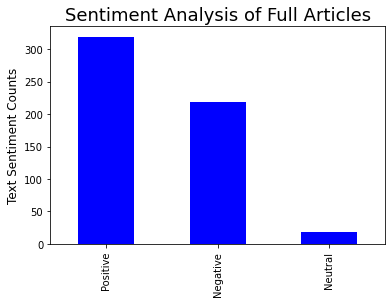

In [16]:
counts = df2['sentiment_text'].value_counts()
counts.plot(kind='bar', color='blue')
plt.ylabel('Text Sentiment Counts', size=12)
plt.title('Sentiment Analysis of Full Articles', size=18)
plt.show()

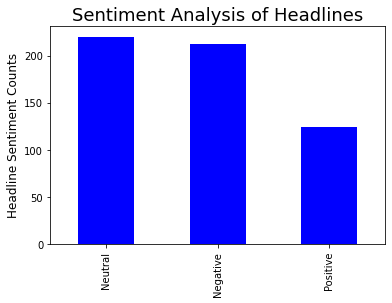

In [17]:
counts = df2['sentiment_headline'].value_counts()
counts.plot(kind='bar', color='blue')
plt.ylabel('Headline Sentiment Counts', size=12)
plt.title('Sentiment Analysis of Headlines', size=18)
plt.show()